# Влияние параметров на динамику системы

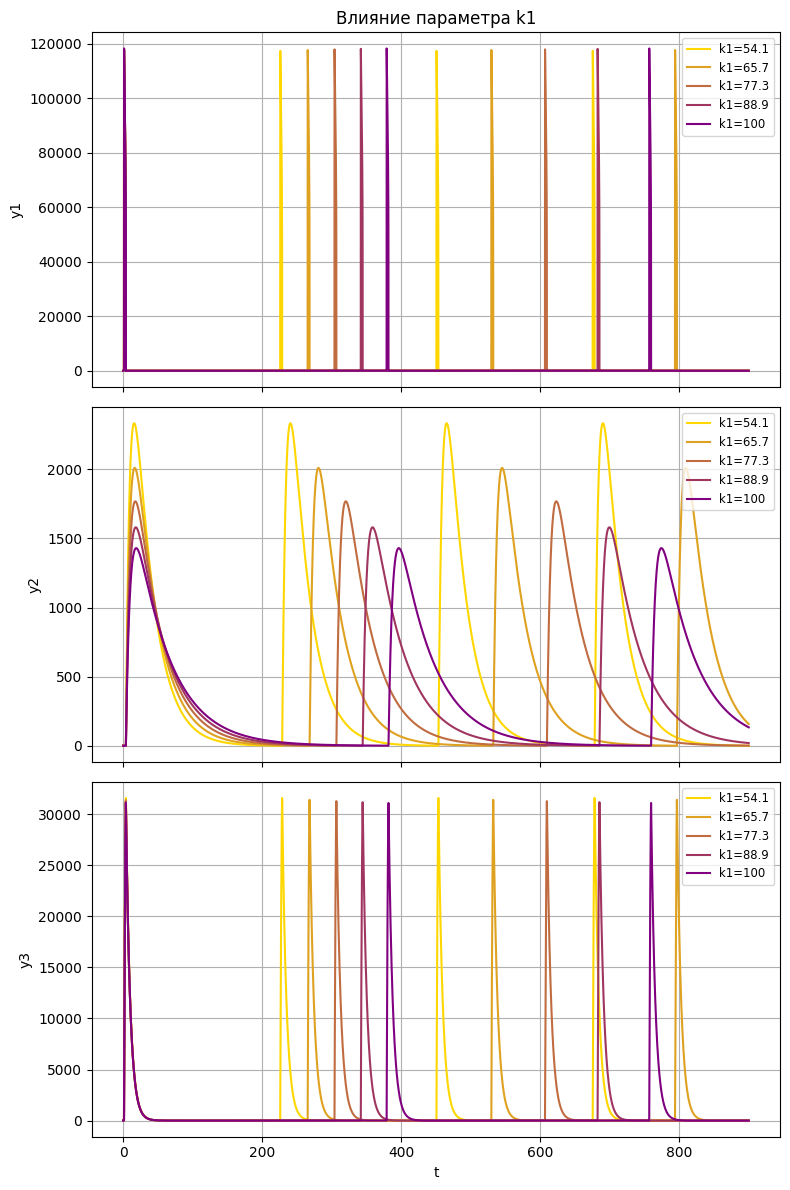

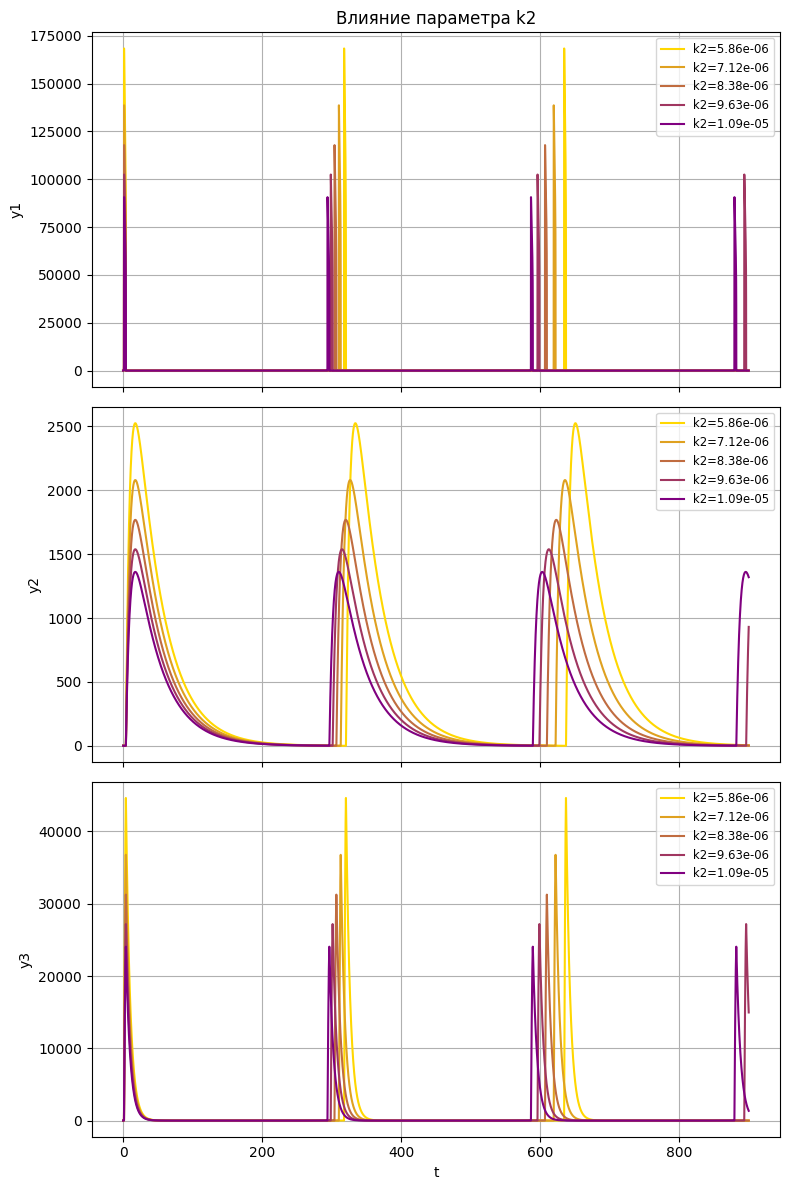

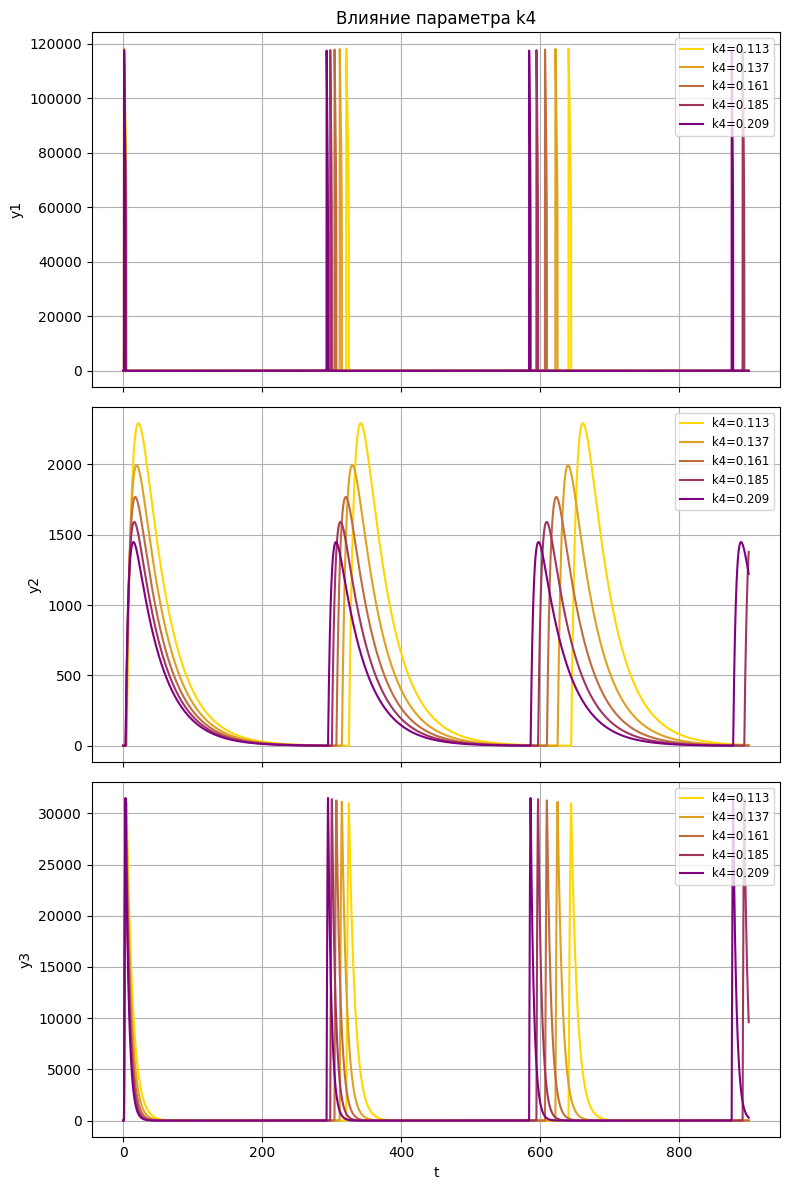

In [38]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


base = {
    'k1': 77.27,
    'k2': 8.375e-6,
    'k4': 0.161,
}

K = 5
deltas = {
    key: np.linspace(0.7 * val, 1.3 * val, K)
    for key, val in base.items()
}

y0 = [4.0, 1.1, 4.0]
a, b = 0.0, 900.0
n_steps = 100000

colors = ["#FFD700", "#800080"]
cmap = LinearSegmentedColormap.from_list("yellow_purple", colors, N=K)


def jacobian(f, t, y, eps=1e-8):
    m = len(y)
    J = np.zeros((m, m))
    f0 = np.array(f(t, y))
    for j in range(m):
        y_eps = y.copy()
        y_eps[j] += eps
        J[:, j] = (np.array(f(t, y_eps)) - f0) / eps
    return J


def irk2(f, y0, a, b, n=1, tol=1e-10, max_iter=50):
    h = (b - a) / n
    t = np.linspace(a, b, n+1)
    m = len(y0)
    y = np.zeros((n+1, m))
    y[0] = y0.copy()

    for i in range(n):
        ti, yi = t[i], y[i]
        ti1 = t[i+1]
        Y = yi + h * np.array(f(ti, yi))
        for _ in range(max_iter):
            F = np.array(f(ti1, Y))
            G = Y - yi - (h/2)*(np.array(f(ti, yi)) + F)
            Jg = np.eye(m) - (h/2)*jacobian(f, ti1, Y)
            Jg += 1e-8*np.eye(m)
            delta = np.linalg.solve(Jg, G)
            Y -= delta
            if np.linalg.norm(delta) < tol:
                break
        y[i+1] = Y

    return t, y


def bdf2(f, y0, a, b, n=100, tol=1e-10, max_iter=50):
    h = (b - a) / n
    t = np.linspace(a, b, n+1)
    m = len(y0)
    y = np.zeros((n+1, m))
    y[0] = y0.copy()

    _, yi = irk2(f, y0, a, a+h, n=1, tol=tol, max_iter=max_iter)
    y[1] = yi[-1]

    alpha1, alpha2 = 4/3, -1/3
    beta = 2/3

    for i in range(1, n):
        ti1 = t[i+1]
        y_nm1, y_n = y[i-1], y[i]
        Y = y_n + (y_n - y_nm1)
        for _ in range(max_iter):
            F = np.array(f(ti1, Y))
            G = Y - alpha1*y_n - alpha2*y_nm1 - beta*h*F
            Jg = np.eye(m) - beta*h*jacobian(f, ti1, Y)
            Jg += 1e-8*np.eye(m)
            delta = np.linalg.solve(Jg, G)
            Y -= delta
            if np.linalg.norm(delta) < tol:
                break
        y[i+1] = Y

    return t, y


def build_f(params):
    def f(t, y):
        k1 = params['k1']
        k2 = params['k2']
        k3 = 1 / params['k1']
        k4 = params['k4']
        y1, y2, y3 = y
        dy1 = k1 * (y2 - y1*y2 + y1 - k2*y1**2)
        dy2 = k3 * (-y2 - y1*y2 + y3)
        dy3 = k4 * (y1 - y3)
        return [dy1, dy2, dy3]
    return f


def run_colormap(vary_param):
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
    labels = ['y1', 'y2', 'y3']

    for idx, new_val in enumerate(deltas[vary_param]):
        params = base.copy()
        params[vary_param] = new_val
        f = build_f(params)

        t, Y = irk2(f, y0, a, b, n=n_steps, tol=1e-8)

        for ax_idx, ax in enumerate(axes):
            ax.plot(t, Y[:, ax_idx],
                    color=cmap(idx),
                    label=f"{vary_param}={new_val:.3g}")
            ax.set_ylabel(labels[ax_idx])
            # ax.set_yscale('log')
            ax.grid(True)

    axes[-1].set_xlabel("t")
    axes[0].set_title(f"Влияние параметра {vary_param}")
    for ax in axes:
        ax.legend(fontsize='small', loc='upper right')
    plt.tight_layout()
    plt.show()


for param in ['k1', 'k2', 'k4']:
    run_colormap(param)

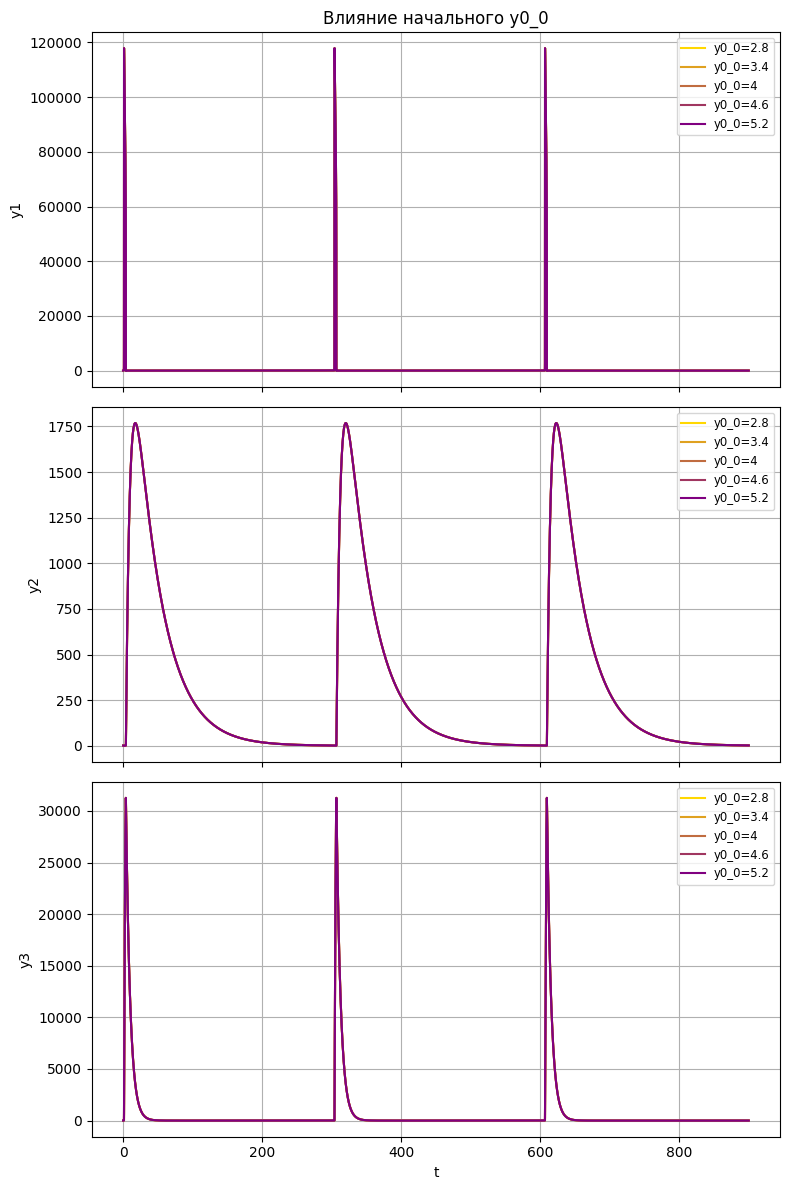

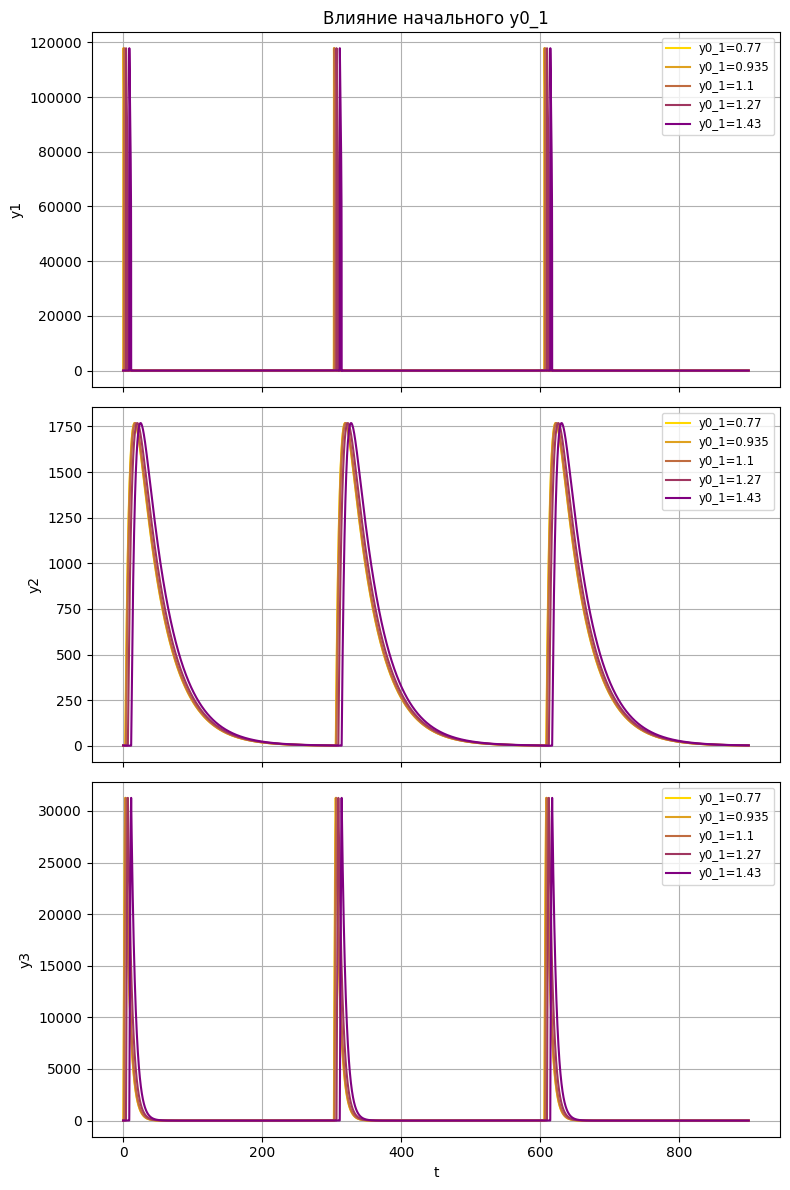

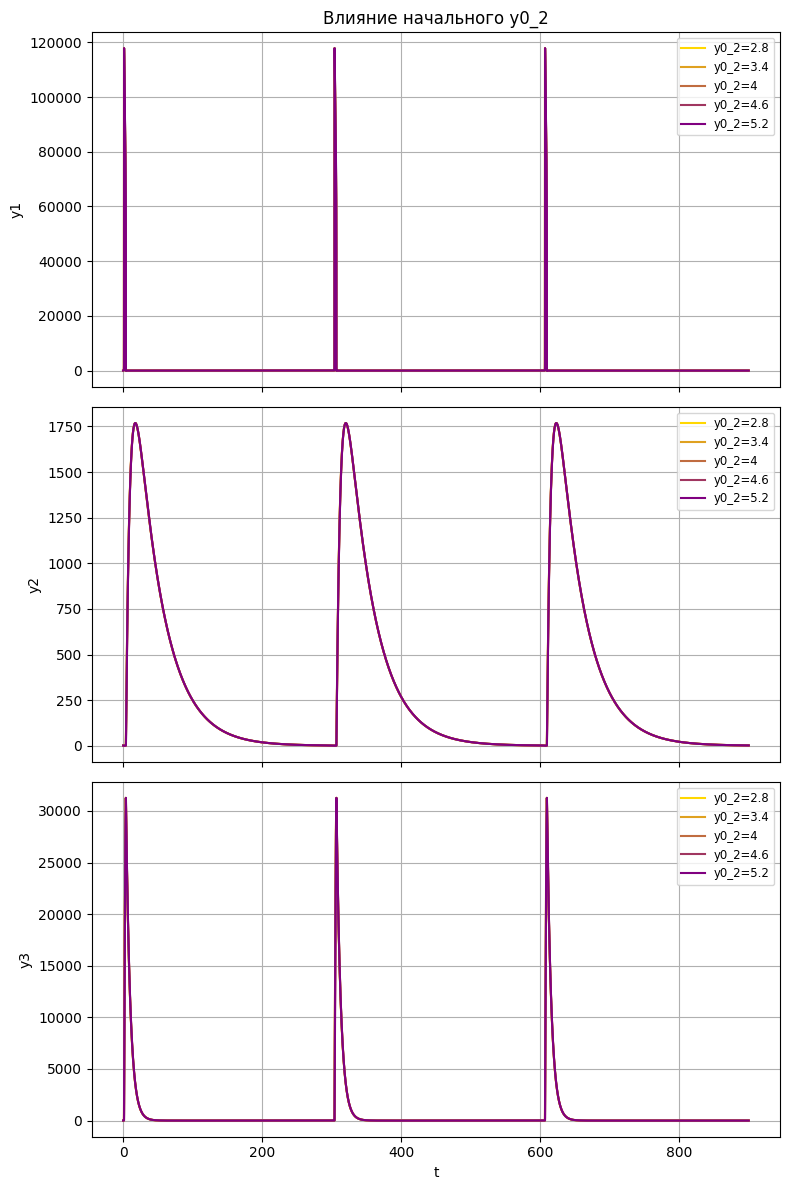

In [40]:
K = 5
y0_base = np.array([4.0, 1.1, 4.0])
deltas_y0 = {
    i: np.linspace(0.7 * y0_base[i], 1.3 * y0_base[i], K)
    for i in range(len(y0_base))
}

def run_colormap_y0(vary_idx):
    fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
    labels = ['y1', 'y2', 'y3']

    for idx, new_y0_val in enumerate(deltas_y0[vary_idx]):
        y0 = y0_base.copy()
        y0[vary_idx] = new_y0_val
        
        f = build_f(base)

        t, Y = irk2(f, y0, a, b, n=n_steps, tol=1e-8)

        for ax_idx, ax in enumerate(axes):
            ax.plot(t, Y[:, ax_idx],
                    color=cmap(idx),
                    label=f"y0_{vary_idx}={new_y0_val:.3g}")
            ax.set_ylabel(labels[ax_idx])
            ax.grid(True)

    axes[-1].set_xlabel("t")
    axes[0].set_title(f"Влияние начального y0_{vary_idx}")
    for ax in axes:
        ax.legend(fontsize='small', loc='upper right')
    plt.tight_layout()
    plt.show()


for idx in range(3):
    run_colormap_y0(idx)